In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np

from darkmod.utils import crop

fontsize = 24  # General font size for all text
ticksize = 24  # tick size
plt.rcParams["font.size"] = fontsize
plt.rcParams["xtick.labelsize"] = ticksize
plt.rcParams["ytick.labelsize"] = ticksize

In [2]:
def load_peak_table(savedir, zis, reflections):
    """
    Load the peak table from a series of npz files.

    The output data table holds data from multiple simulations
    with both ground truth and reconstructed data.

    The filepath names are assumed to follow the patterns:
    reflection_1_zi_m1.npz, reflection_1_zi_1.npz ... etc
    (where m1 stands for zi=-1)

    Args:
        savedir (str): Directory where the data is saved
        zis (list): List of z values (e.g. [-1, 0, 1])
        reflections (list): List of reflections (e.g. [1, 2, 3, 4])

    Returns:
        data (np.array): Array of npz files of shape (4, 3).
            each data instance is a dictionary with keys.
    """
    data = np.empty((4, 3), dtype=object)
    for reflection in reflections:
        for zi in zis:
            if zi < 0:
                ss = "_zi_m" + str(np.abs(zi))
            else:
                ss = "_zi_" + str(zi)
            fname = "reflection_" + str(reflection) + ss
            file = os.path.join(savedir, fname + ".npz")
            data[reflection - 1, zi + 1] = np.load(file)
    return data


def load_scan(data, zi, reflection):
    """Load the strain-mosa scan from the data array.

    Args:
        data (npz dictionary): Data array instance from the npz file.
        zi (int): Index of the z value in the data array.
        reflection (int): Index of the reflection in the data array.

    Returns:
        scan (np.array): Strain-mosa scan of shape (m, n, o, p, q).
            first two dimensions are the pixel dimensions, and the last
            three dimensions are the strain-mosa dimensions (th, phi, chi).
    """
    d = data[reflection - 1, zi + 1]
    scan = np.zeros(d["strain_mosa_shape"], dtype=np.uint32).flatten()
    scan[d["sparse_indices"]] = d["strain_mosa_sparse"]
    scan = scan.reshape(d["strain_mosa_shape"])
    return scan


def show_sample_frame(data, zi, reflection):
    """Plot the central (angular) frame of the strain-mosa scan."""
    scan = load_scan(data, zi, reflection)
    m, n, o, p, q = scan.shape
    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    _s = scan[:, :, o // 2, p // 2, q // 2].astype(np.float32)
    mask = data[reflection - 1, zi + 1]["intensity_mask"]
    im = ax.imshow(crop(_s, mask), cmap="plasma", vmin=44000, vmax=54000)
    fig.colorbar(im, ax=ax, fraction=0.0235, pad=0.04)
    for spine in ax.spines.values():
        spine.set_visible(False)
    plt.title(
        "Reflection " + str(reflection) + " at zi = " + str(zi) + "   [arb. units]"
    )
    plt.xlabel("Pixel column")
    plt.ylabel("Pixel row")
    plt.tight_layout()
    plt.show()


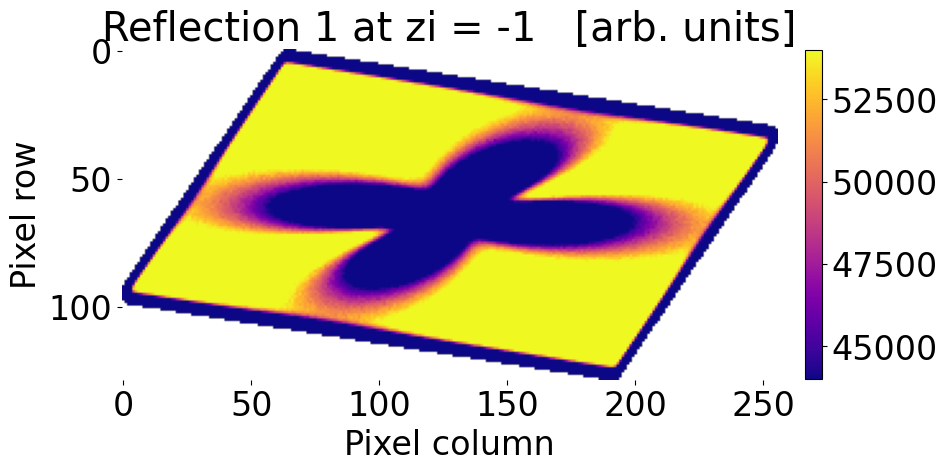

In [3]:
# Path to the directory in which reflections are stored
savedir = "/home/naxhe/workspace/darkmod/tests/end_to_end/defrec/saves/paper_1_run_3"
zis = [-1, 0, 1]
reflections = [1, 2, 3, 4]
# reflections = [2]
data = load_peak_table(savedir, zis, reflections)
show_sample_frame(data, zi=zis[0], reflection=reflections[0])


In [4]:
reflection = 1
zi = -1
d = data[reflection - 1, zi + 1]
scan = np.zeros(d["strain_mosa_shape"], dtype=np.uint32).flatten()
scan[d["sparse_indices"]] = d["strain_mosa_sparse"]
scan_pattern = np.sum(scan.reshape(d["strain_mosa_shape"]), axis=(0, 1))

In [5]:
scan[scan > 0].min()

1

In [6]:
(
    scan_pattern.size,
    scan_pattern.max(),
    scan_pattern.min(),
    (scan_pattern > 5 * 41 * 41 * 11).sum(),
)

(18491, 1011403402, 84390, 3569)

In [7]:
scan_pattern.shape

(11, 41, 41)

Reflection 1, zi = 0, max = 1011499889, min = 84433
[-1 -1  3]
(41, 41, 4)


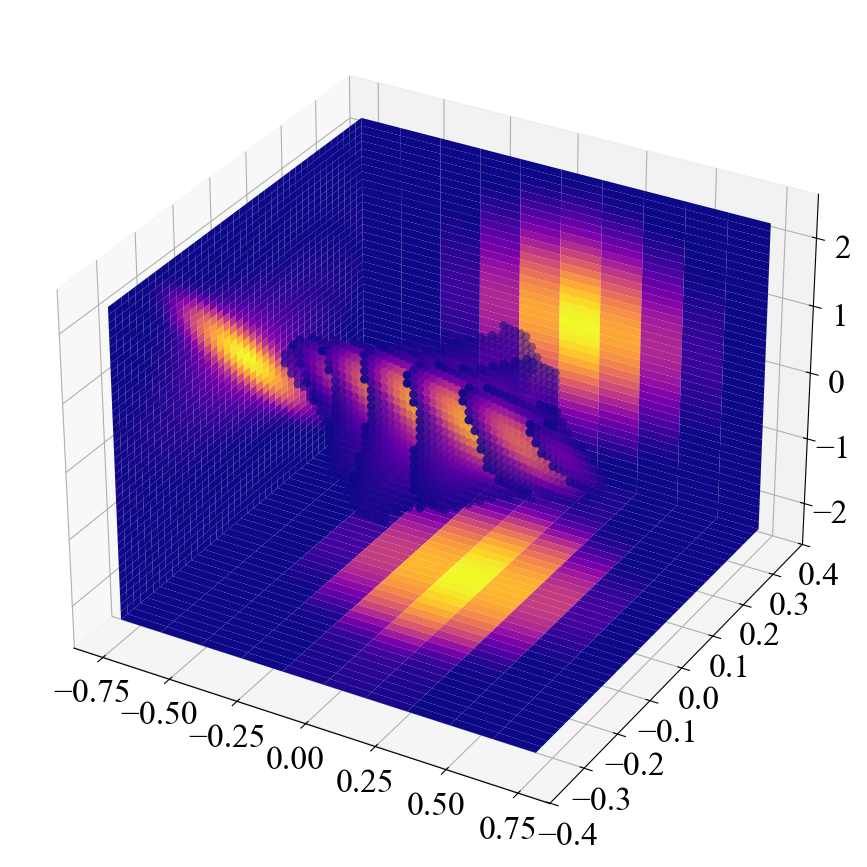

Reflection 2, zi = 0, max = 902308240, min = 84457
[-1.  1.  3.]
(41, 41, 4)


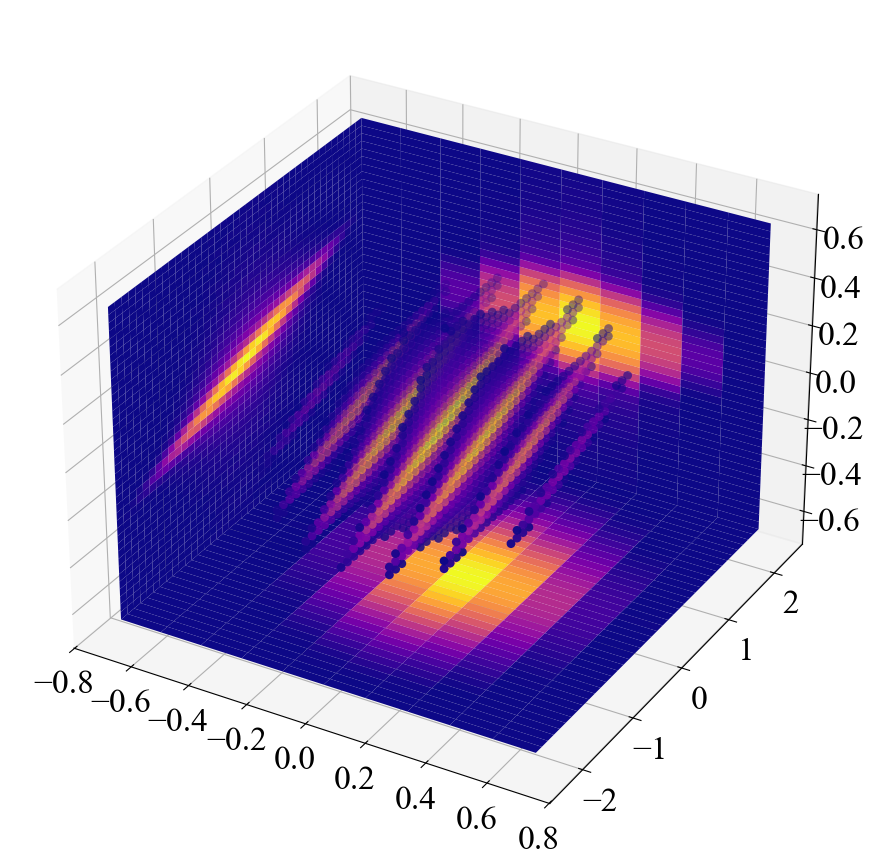

Reflection 3, zi = 0, max = 1212820525, min = 83808
[1. 1. 3.]
(41, 41, 4)


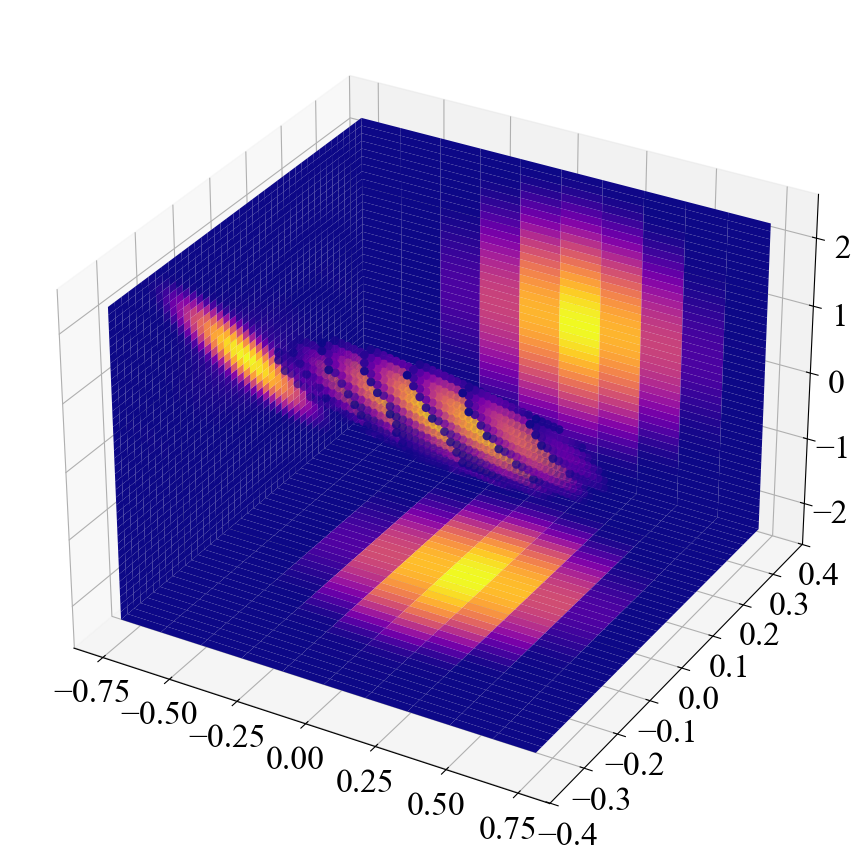

Reflection 4, zi = 0, max = 1183244303, min = 84375
[ 1. -1.  3.]
(41, 41, 4)


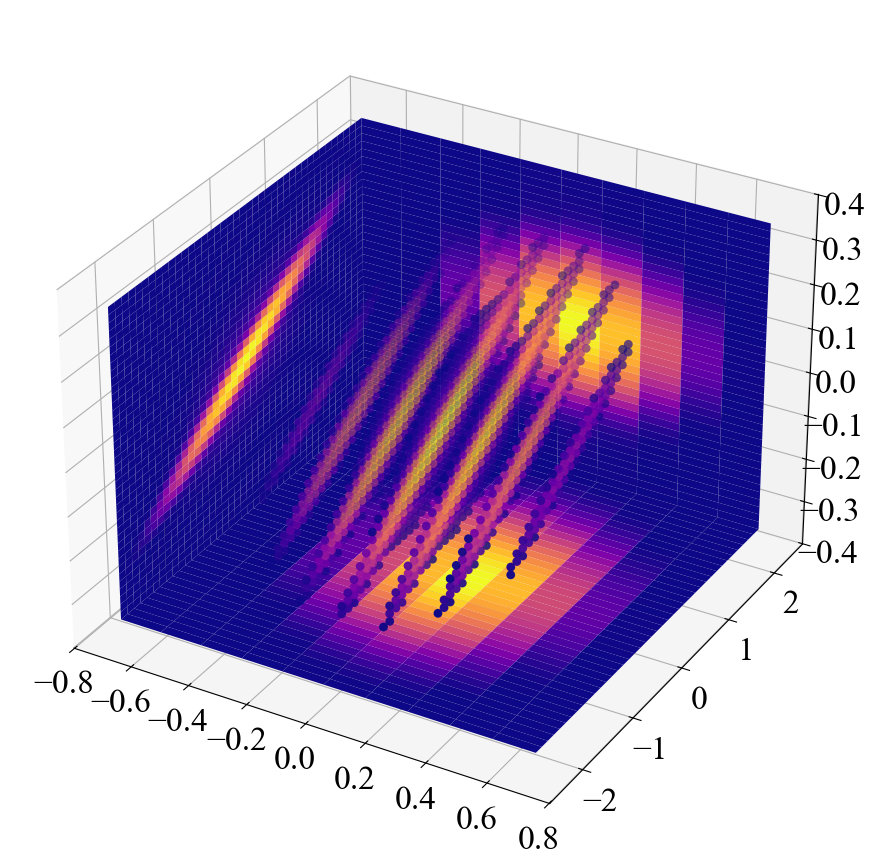

In [8]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
from matplotlib.colors import Normalize

for reflection in reflections:
    for zi in [0]:
        d = data[reflection - 1, zi + 1]
        scan = np.zeros(d["strain_mosa_shape"], dtype=np.uint32).flatten()
        scan[d["sparse_indices"]] = d["strain_mosa_sparse"]
        scan_pattern = np.sum(scan.reshape(d["strain_mosa_shape"]), axis=(0, 1))
        print(
            f"Reflection {reflection}, zi = {zi}, max = {scan_pattern.max()}, min = {scan_pattern.min()}"
                
                )
        # print kl
        print(d['hkl'])
        theta_values = data[reflection - 1, zi + 1]["delta_theta"]*1e3
        phi_values = data[reflection - 1, zi + 1]["phi"]*1e3
        chi_values = data[reflection - 1, zi + 1]["chi"]*1e3
        theta_mesh, phi_mesh, chi_mesh = np.meshgrid(theta_values, phi_values, chi_values, indexing="ij")


        plt.rcParams["font.family"] = "Times New Roman"

        cmap = cm.plasma

        threshold = 7
        voxels = scan_pattern > 41 * 41 * 11 * threshold

        values = np.log(scan_pattern)
        norm_values = (values - values.min()) / (values.max() - values.min())
        colors = cmap(norm_values)
        fig, ax = plt.subplots(1,1, subplot_kw={'projection': '3d'},figsize=(11, 11))

        ax.computed_zorder = False

        x = theta_mesh[voxels]
        y = phi_mesh[voxels]
        z = chi_mesh[voxels]

        array = values.sum(axis=2)
        norm = Normalize()
        colors = plt.get_cmap(cmap)(norm(array))
        xii, yii = np.meshgrid(theta_values, phi_values, indexing="ij")
        zii = np.full_like(yii, np.min(chi_values))
        ax.plot_surface(xii, yii, zii, rstride=1, cstride=1, facecolors=colors, shade=False, linewidth=0)

        array = values.sum(axis=1)
        norm = Normalize()
        colors = plt.get_cmap(cmap)(norm(array))
        xii, zii = np.meshgrid(theta_values, chi_values, indexing="ij")
        yii = np.full_like(zii, np.max(phi_values))
        ax.plot_surface(xii, yii, zii, rstride=1, cstride=1, facecolors=colors, shade=False, linewidth=0)

        array = norm_values.sum(axis=0)
        norm = Normalize()
        colors = plt.get_cmap(cmap)(norm(array))
        yii, zii = np.meshgrid(phi_values, chi_values, indexing="ij")
        xii = np.full_like(zii, np.min(theta_values))
        print(colors.shape)
        ax.plot_surface(xii, yii, zii, rstride=1, cstride=1, facecolors=colors, shade=False, linewidth=0)

        ax.scatter3D(x, y, z, c=values[voxels], cmap=cmap, s=40, marker='o', linestyle='solid', linewidth=0.0, edgecolor='k')

        plt.show()


In [10]:
np.min(chi_mesh)

-0.35

NameError: name 'imshow3d' is not defined

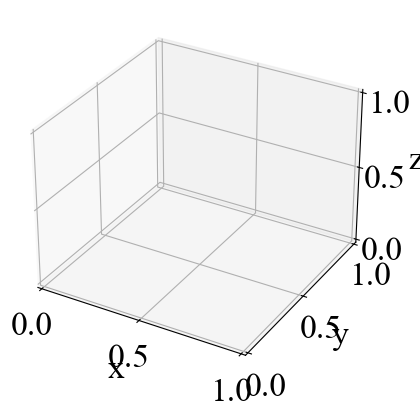

In [11]:
fig = plt.figure()
ax = fig.add_subplot(projection="3d")
ax.set(xlabel="x", ylabel="y", zlabel="z")

nx, ny, nz = 8, 10, 5
data_xy = np.arange(ny * nx).reshape(ny, nx) + 15 * np.random.random((ny, nx))
data_yz = np.arange(nz * ny).reshape(nz, ny) + 10 * np.random.random((nz, ny))
data_zx = np.arange(nx * nz).reshape(nx, nz) + 8 * np.random.random((nx, nz))

imshow3d(ax, data_xy)
imshow3d(ax, data_yz, value_direction="x", cmap="magma")
imshow3d(ax, data_zx, value_direction="y", pos=ny, cmap="plasma")

plt.show()

In [12]:
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams.update(matplotlib.rcParamsDefault)
plt.rcParams.update(
    {"text.usetex": False, "font.family": "serif", "font.serif": "Times New Roman"}
)


In [13]:
X.shape

NameError: name 'X' is not defined

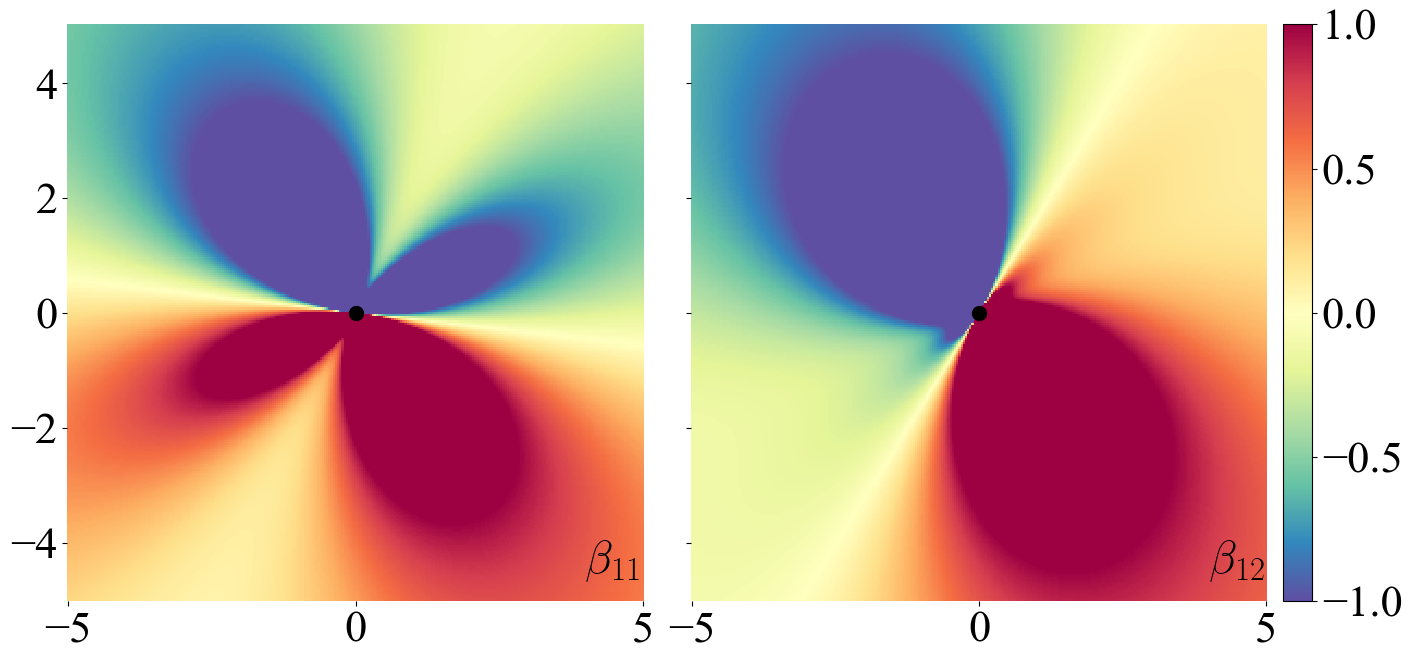

In [14]:
reflection = 1
zi = 0
d = data[reflection - 1, zi + 1]
beta = d["defgrad"]
for i in range(3):
    beta[..., i, i] -= 1


X, Y, Z = d["X"], d["Y"], d["Z"]
xx = X[:, :, X.shape[2] // 2]
yy = Y[:, :, Y.shape[2] // 2]

# plt.style.use("default")
fontsize = 32  # General font size for all text
ticksize = 32  # tick size
plt.rcParams["font.size"] = fontsize
plt.rcParams["xtick.labelsize"] = ticksize
plt.rcParams["ytick.labelsize"] = ticksize

plt.rcParams["font.family"] = "Times New Roman"

fig, ax = plt.subplots(
    1, 2, figsize=(14, 7), sharex=True, sharey=True, layout="compressed"
)
im = ax[0].pcolormesh(
    xx,
    yy,
    beta[:, :, X.shape[2] // 2, 0, 0] * 1e5,
    cmap="Spectral_r",
    shading="auto",
    vmin=-1,
    vmax=1,
)
ax[0].annotate(
    r"$\beta_{11}$",
    xy=(0.9, 0.05),
    xycoords="axes fraction",
    fontsize=fontsize + 2,
    usetex=True,
)

ax[0].axes.set_aspect("equal")
# ax[0].set_xlabel(r"x [$\mu$m]")
# ax[0].set_ylabel(r"y [$\mu$m]")
for spine in ax[0].spines.values():
    spine.set_visible(False)
# cbar = fig.colorbar(im, ax=ax[0], fraction=0.0471, pad=0.01)

im = ax[1].pcolormesh(
    xx,
    yy,
    beta[:, :, X.shape[2] // 2, 1, 2] * 1e5,
    cmap="Spectral_r",
    shading="auto",
    vmin=-1,
    vmax=1,
)
ax[1].annotate(
    r"$\beta_{12}$",
    xy=(0.9, 0.05),
    xycoords="axes fraction",
    fontsize=fontsize + 2,
    usetex=True,
)


for a in ax.flatten():
    a.scatter(0, 0, color="black", s=100)

ax[1].axes.set_aspect("equal")
# ax[1].set_xlabel(r"x")
for spine in ax[1].spines.values():
    spine.set_visible(False)
cbar = fig.colorbar(im, ax=ax[1], pad=0.01)
# plt.colorbar(im, ax=ax[1])
# cbar.set_label('[units of $10^{-5}$]', rotation=270)

plt.show()


In [15]:
import matplotlib as mpl

mpl.matplotlib_fname()

'/home/naxhe/anaconda3/envs/xrd/lib/python3.10/site-packages/matplotlib/mpl-data/matplotlibrc'

In [16]:
reflection=0
zi=0
d = data[reflection - 0, zi + 1]
scan = np.zeros(d["strain_mosa_shape"], dtype=np.uint32).flatten()
scan[d["sparse_indices"]] = d["strain_mosa_sparse"]
scan = scan.reshape(d["strain_mosa_shape"])
print(
    f"Reflection {reflection}, zi = {zi}, max = {scan_pattern.max()}, min = {scan_pattern.min()}"
        
        )
# print kl
print(d['hkl'])

Reflection 0, zi = 0, max = 1183244303, min = 84375
[-1 -1  3]


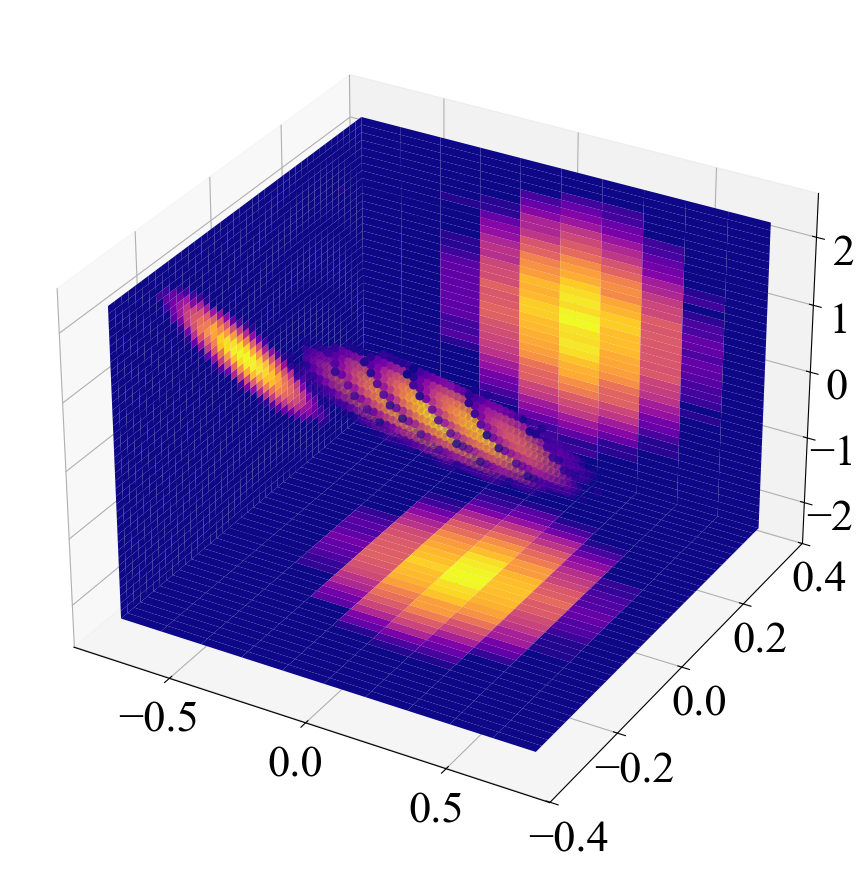

Theta values: -0.45000000000000007
Phi values: 0.06999999999999995
Chi values: 0.45999999999999996


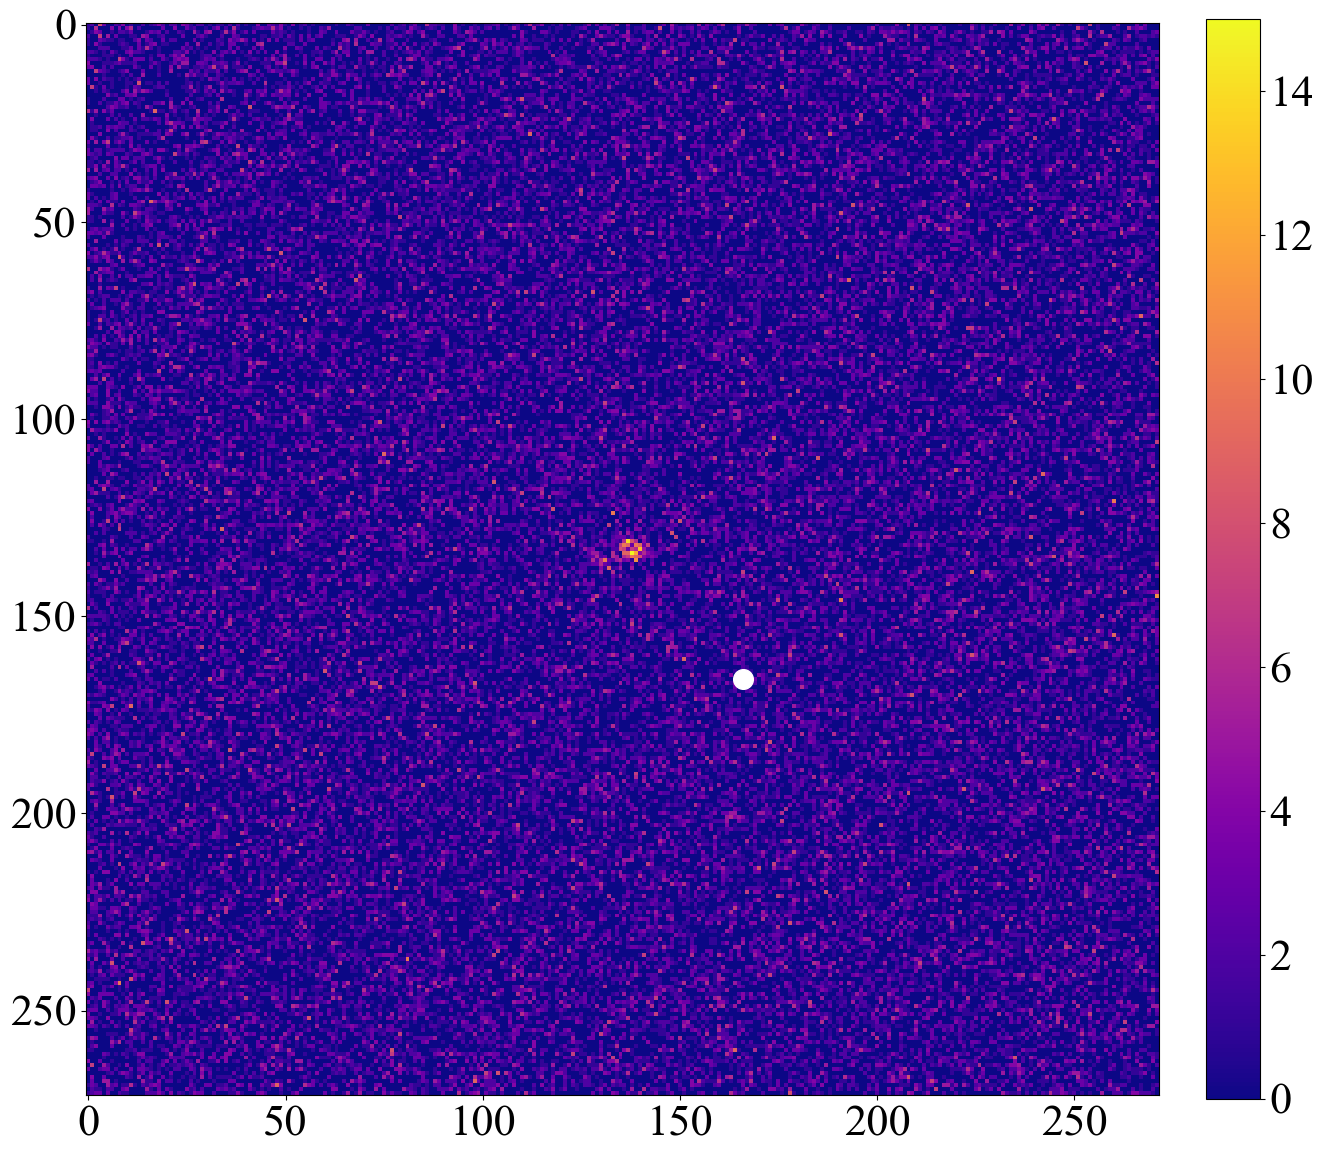

In [20]:
import matplotlib

matplotlib.rcParams.update(matplotlib.rcParamsDefault)
plt.rcParams.update(
    {"text.usetex": False, "font.family": "serif", "font.serif": "Times New Roman"}
)

fontsize = 32  # General font size for all text
ticksize = 32  # tick size
plt.rcParams["font.size"] = fontsize
plt.rcParams["xtick.labelsize"] = ticksize
plt.rcParams["ytick.labelsize"] = ticksize

plt.rcParams["font.family"] = "Times New Roman"

row, col = scan.shape[0]//2, scan.shape[1]//2
col += 30
row += 30
agular_map = scan[row, col, ...]

theta_values = data[reflection - 0, zi + 1]["delta_theta"]*1e3
phi_values = data[reflection - 0, zi + 1]["phi"]*1e3
chi_values = data[reflection - 0, zi + 1]["chi"]*1e3
theta_mesh, phi_mesh, chi_mesh = np.meshgrid(theta_values, phi_values, chi_values, indexing="ij")

threshold = 9
voxels = agular_map > threshold

x = theta_mesh[voxels]
y = phi_mesh[voxels]
z = chi_mesh[voxels]




cmap = cm.plasma
values[voxels] = np.log(agular_map[voxels])
values[~voxels] = 0
norm_values = (values - values.min()) / (values.max() - values.min())
colors = cmap(norm_values)

fig, ax = plt.subplots(1,1, subplot_kw={'projection': '3d'},figsize=(11, 11))
ax.computed_zorder = False

array = values.sum(axis=2)
norm = Normalize()
colors = plt.get_cmap(cmap)(norm(array))
xii, yii = np.meshgrid(theta_values, phi_values, indexing="ij")
zii = np.full_like(yii, np.min(chi_values))
ax.plot_surface(xii, yii, zii, rstride=1, cstride=1, facecolors=colors, shade=False, linewidth=0)

array = values.sum(axis=1)
norm = Normalize()
colors = plt.get_cmap(cmap)(norm(array))
xii, zii = np.meshgrid(theta_values, chi_values, indexing="ij")
yii = np.full_like(zii, np.max(phi_values))
ax.plot_surface(xii, yii, zii, rstride=1, cstride=1, facecolors=colors, shade=False, linewidth=0)

array = norm_values.sum(axis=0)
norm = Normalize()
colors = plt.get_cmap(cmap)(norm(array))
yii, zii = np.meshgrid(phi_values, chi_values, indexing="ij")
xii = np.full_like(zii, np.min(theta_values))
ax.plot_surface(xii, yii, zii, rstride=1, cstride=1, facecolors=colors, shade=False, linewidth=0)


ax.scatter3D(x, y, z, c=norm_values[voxels], cmap=cmap, s=40, marker='o', linestyle='solid', linewidth=0.0, edgecolor='k')


plt.show()
print('Theta values:', theta_values[scan.shape[2]//2 -3])
print('Phi values:', phi_values[scan.shape[3]//2 + 4])
print('Chi values:', chi_values[scan.shape[4]//2 + 4])
fig, ax = plt.subplots(1, 1, figsize=(14,14))

I = scan[:,:, scan.shape[2]//2 -3,scan.shape[3]//2 + 4,scan.shape[4]//2 + 4].astype(np.float32)
im = ax.imshow(I, cmap='plasma')
ax.scatter(col, row, color='white', s=200)
fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()


In [10]:


cmap = cm.plasma

threshold = 7
voxels = scan_pattern > 41 * 41 * 11 * threshold

values = np.log(scan_pattern)
norm_values = (values - values.min()) / (values.max() - values.min())
colors = cmap(norm_values)
fig, ax = plt.subplots(1,1, subplot_kw={'projection': '3d'},figsize=(11, 11))

ax.computed_zorder = False

x = theta_mesh[voxels]
y = phi_mesh[voxels]
z = chi_mesh[voxels]

array = values.sum(axis=2)
norm = Normalize()
colors = plt.get_cmap(cmap)(norm(array))
xii, yii = np.meshgrid(theta_values, phi_values, indexing="ij")
zii = np.full_like(yii, np.min(chi_values))
ax.plot_surface(xii, yii, zii, rstride=1, cstride=1, facecolors=colors, shade=False, linewidth=0)

array = values.sum(axis=1)
norm = Normalize()
colors = plt.get_cmap(cmap)(norm(array))
xii, zii = np.meshgrid(theta_values, chi_values, indexing="ij")
yii = np.full_like(zii, np.max(phi_values))
ax.plot_surface(xii, yii, zii, rstride=1, cstride=1, facecolors=colors, shade=False, linewidth=0)

array = norm_values.sum(axis=0)
norm = Normalize()
colors = plt.get_cmap(cmap)(norm(array))
yii, zii = np.meshgrid(phi_values, chi_values, indexing="ij")
xii = np.full_like(zii, np.min(theta_values))
print(colors.shape)
ax.plot_surface(xii, yii, zii, rstride=1, cstride=1, facecolors=colors, shade=False, linewidth=0)

ax.scatter3D(x, y, z, c=values[voxels], cmap=cmap, s=40, marker='o', linestyle='solid', linewidth=0.0, edgecolor='k')

plt.show()


Reflection 0, zi = 0, max = 63694, min = 0
[ 1. -1.  3.]
